In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import colorcet as cc
import plotly.express as px

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
%matplotlib inline

config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'newplot',
    'height': 500,
    'width': 900,
    'scale': 5 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

In [2]:
df=pd.read_pickle('./dataset_/dataset_cleaned_popularity.pkl')
df.drop(columns=['index', 'level_0'], inplace=True)  # Comes from pickeling the file
df.reset_index(drop=True, inplace=True)

In [3]:
df['popularity'].describe()

count    166681.000000
mean       5511.366120
std       13236.831027
min           0.800000
25%          78.400000
50%         530.400000
75%        3995.050000
max      233766.900000
Name: popularity, dtype: float64

## Popularity Prediction
This week, we started to work on our predictive mining tasks, one of them is song popularity prediction. By the end of this project, we hope that we can see what is the typical song that is getting more popular than the others in Spotify. We got two ideas in mind, which are popularity score prediction and popularity classification (popular / not popular).

### Data Pre-processing
Before jump into the main modelling task, here we'll process all of our our possible features based on its data type:

**Numerical Features**
* popularity
* artist_followers
* danceability
* energy
* loudness
* speechiness
* acoustics
* instrumentalness
* liveness
* valence
* duration_min

**Categorical Features**
* explicit
* key
* mode
* release_day

For the first round selection, we selected the features based on our knowledge and common sense, later we'll try to fit in all these features into some models first and see how they perform.
#### Popularity
The original value of our popularity score is the calculation of number of days and position they stayed in the Top 200 Playlist and the score is also difference for each country.

In [4]:
df.sort_values(by='popularity', ascending=False).head(5)

,country,uri,popularity,title,artist,release_type,sub_genre,artist_followers,explicit,album,release_date,track_number,tracks_in_album,danceability,energy,key,loudness,mode,speechiness,acoustics,instrumentalness,liveness,valence,tempo,time_signature,genre,days_since_release,released_after_2017,explicit_false,explicit_true,popu_max,top10_dummy,top50_dummy,cluster,duration_min,release_year,release_month,release_day
52226,Belgium,https://open.spotify.com/track/7qiZfU4dY1lWllz...,233766.9,shape of you,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),2017-03-03,4,16,0.825,0.652,1,-3.183,0,0.0802,0.581,0.0,0.0931,0.931,95.977,4,pop,1349.0,1.0,1,0,1,1.0,1.0,english speaking and nordic,3.895217,2017,3,3
52232,Costa Rica,https://open.spotify.com/track/7qiZfU4dY1lWllz...,228707.2,shape of you,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),2017-03-03,4,16,0.825,0.652,1,-3.183,0,0.0802,0.581,0.0,0.0931,0.931,95.977,4,pop,1349.0,1.0,1,0,1,1.0,1.0,spanish speaking,3.895217,2017,3,3
52220,Global,https://open.spotify.com/track/7qiZfU4dY1lWllz...,221571.0,shape of you,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),2017-03-03,4,16,0.825,0.652,1,-3.183,0,0.0802,0.581,0.0,0.0931,0.931,95.977,4,pop,1349.0,1.0,1,0,1,1.0,1.0,global,3.895217,2017,3,3
30287,Philippines,https://open.spotify.com/track/5uCax9HTNlzGybI...,217605.8,say you wont let go,James Arthur,album,pop,6843219.0,False,Back from the Edge,2016-10-28,2,17,0.358,0.557,10,-7.398,1,0.0590,0.695,0.0,0.0902,0.494,85.043,4,pop,1469.0,0.0,1,0,2,1.0,1.0,southern europe and portuguese heritage,3.524450,2016,10,28
52252,Singapore,https://open.spotify.com/track/7qiZfU4dY1lWllz...,217307.4,shape of you,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),2017-03-03,4,16,0.825,0.652,1,-3.183,0,0.0802,0.581,0.0,0.0931,0.931,95.977,4,pop,1349.0,1.0,1,0,1,1.0,1.0,english speaking and nordic,3.895217,2017,3,3


As you can see in the table, there are multiple countries that have "Shape of You" as their top popular song, and this also means that this song is very popular compared to a song that only appears in one coutnry top playlist, right?

So, in order to get a unique song popularity score, we decided to sum up the every country's popularity score for each song, since the higher value they got, means the more popular they are.

In [5]:
df = df.groupby(['title', 'artist', 'release_type', 'sub_genre', 'artist_followers', 'explicit', 'album', 'track_number', 'tracks_in_album', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acoustics', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'genre', 'duration_min', 'release_year', 'release_month', 'release_day'])['popularity'].sum().reset_index(name='popularity')
df.sort_values(by='popularity', ascending=False).head(5)

,title,artist,release_type,sub_genre,artist_followers,explicit,album,track_number,tracks_in_album,danceability,energy,key,loudness,mode,speechiness,acoustics,instrumentalness,liveness,valence,tempo,time_signature,genre,duration_min,release_year,release_month,release_day,popularity
44367,shape of you,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),4,16,0.825,0.652,1,-3.183,0,0.0802,0.581,0.000000,0.0931,0.931,95.977,4,pop,3.895217,2017,3,3,5732932.35
11089,dance monkey,Tones And I,single,australian pop,2283019.0,False,Dance Monkey,1,1,0.825,0.593,6,-6.401,0,0.0988,0.688,0.000161,0.1700,0.540,98.078,4,pop,3.495917,2019,5,10,3624590.65
38669,perfect,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),5,16,0.599,0.448,8,-6.312,1,0.0232,0.163,0.000000,0.1060,0.168,95.050,3,pop,4.390000,2017,3,3,2933691.50
4480,bad guy,Billie Eilish,album,electropop,34697267.0,False,"WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?",2,14,0.701,0.425,7,-10.965,1,0.3750,0.328,0.130000,0.1000,0.562,135.128,4,pop,3.234800,2019,3,29,2812179.25
44341,shallow,Lady Gaga - Bradley Cooper,album,dance pop,14439685.0,False,A Star Is Born Soundtrack,12,34,0.572,0.385,7,-6.362,1,0.0308,0.371,0.000000,0.2310,0.323,95.799,4,pop,3.595550,2018,10,5,2600171.85


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59492 entries, 0 to 59491
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   title             59492 non-null  object        
 1   artist            59492 non-null  object        
 2   release_type      59492 non-null  object        
 3   sub_genre         59492 non-null  object        
 4   artist_followers  59492 non-null  float64       
 5   explicit          59492 non-null  object        
 6   album             59492 non-null  object        
 7   track_number      59492 non-null  object        
 8   tracks_in_album   59492 non-null  object        
 9   danceability      59492 non-null  float64       
 10  energy            59492 non-null  float64       
 11  key               59492 non-null  object        
 12  loudness          59492 non-null  float64       
 13  mode              59492 non-null  object        
 14  speechiness       5949

As a result, we got 59,492 unique songs.

The mean is way too shifted to the left, even from 59k songs, 51k songs are below average, because the dataset has a few extreme popular songs. But it's not possible to enrich the data again, because the calculation of popularity in our dataset is different between the Spotify one. Consequently, we'll work on the data as it is.

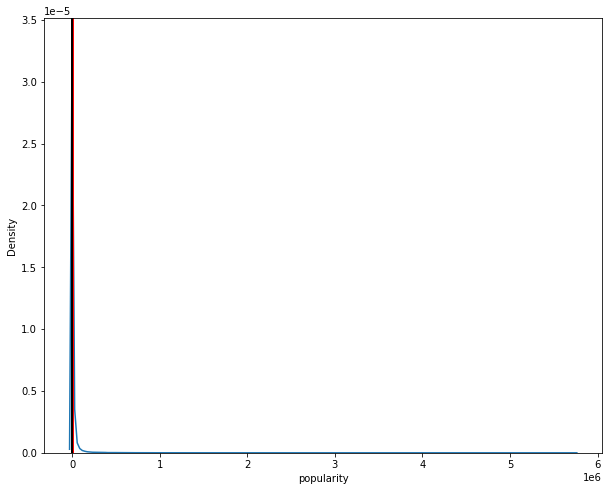

In [6]:
plt.figure(figsize=(10, 8))
sns.kdeplot(df['popularity'])

plt.axvline(df['popularity'].mean(), linewidth = 2, color = 'r')
plt.axvline(df['popularity'].median(), linewidth = 2, color = 'k')
plt.show()

After that, we checked again which feature is needed to be processed.

In [7]:
df.nunique(axis=0)

title               44954
artist              23360
release_type            3
sub_genre            1119
artist_followers     9134
explicit                4
album               32653
track_number           73
tracks_in_album       136
danceability          990
energy               1225
key                    24
loudness            12259
mode                    4
speechiness          1512
acoustics            3551
instrumentalness     5061
liveness             1727
valence              1543
tempo               30613
time_signature          9
genre                  21
duration_min        36712
release_year           79
release_month          12
release_day            31
popularity          36178
dtype: int64

From the result above, you can see that explicit and mode is supposed to have only binary value, but there is 4 unique values instead.

#### Explicit
We will change the string value of "True" and "False" into a boolean one.

In [8]:
df['explicit'].unique()

array([False, True, 'True', 'False'], dtype=object)

In [9]:
df.loc[df.explicit == 'True', 'explicit'] = 1
df.loc[df.explicit == 'False', 'explicit'] = 0
df.loc[df.explicit == True, 'explicit'] = 1
df.loc[df.explicit == False, 'explicit'] = 0

In [10]:
df['explicit'].unique()

array([0, 1], dtype=object)

#### Mode
We will change the string value of "0" and "1" into a numeric one.

In [11]:
df['mode'].unique()

array([1, 0, '1', '0'], dtype=object)

In [12]:
df.loc[df['mode'] == '0', 'mode'] = 0
df.loc[df['mode'] == '1', 'mode'] = 1

In [13]:
df['mode'].unique()

array([1, 0], dtype=object)

In [14]:
df.nunique(axis=0)

title               44954
artist              23360
release_type            3
sub_genre            1119
artist_followers     9134
explicit                2
album               32653
track_number           73
tracks_in_album       136
danceability          990
energy               1225
key                    24
loudness            12259
mode                    2
speechiness          1512
acoustics            3551
instrumentalness     5061
liveness             1727
valence              1543
tempo               30613
time_signature          9
genre                  21
duration_min        36712
release_year           79
release_month          12
release_day            31
popularity          36178
dtype: int64

#### Key
There are duplicated keys, so we tried to convert all of them into numeric values.

In [15]:
df['key'].unique()

array([1, 5, 8, 4, 11, 10, 9, 0, '1', 2, 7, 6, '9', '10', '0', 3, '5',
       '11', '4', '7', '2', '3', '6', '8'], dtype=object)

In [16]:
df.loc[df['key'] == '9', 'key'] = 9
df.loc[df['key'] == '10', 'key'] = 10
df.loc[df['key'] == '0', 'key'] = 0
df.loc[df['key'] == '5', 'key'] = 5
df.loc[df['key'] == '11', 'key'] = 11
df.loc[df['key'] == '4', 'key'] = 4
df.loc[df['key'] == '7', 'key'] = 7
df.loc[df['key'] == '2', 'key'] = 2
df.loc[df['key'] == '3', 'key'] = 3
df.loc[df['key'] == '6', 'key'] = 6
df.loc[df['key'] == '8', 'key'] = 8
df.loc[df['key'] == '1', 'key'] = 1

In [17]:
df['key'].unique()

array([1, 5, 8, 4, 11, 10, 9, 0, 2, 7, 6, 3], dtype=object)

#### Release Day

In [18]:
df['release_date'] = pd.to_datetime(df['release_year'].astype(str) + '-' + df['release_month'].astype(str) + '-' + df['release_day'].astype(str), errors='ignore')
df['weekday'] = df['release_date'].dt.dayofweek
df

,title,artist,release_type,sub_genre,artist_followers,explicit,album,track_number,tracks_in_album,danceability,energy,key,loudness,mode,speechiness,acoustics,instrumentalness,liveness,valence,tempo,time_signature,genre,duration_min,release_year,release_month,release_day,popularity,release_date,weekday
0,!,O.S.T.R.,album,polish hip hop,306856.0,0,W drodze po szczęście,1,15,0.561,0.798,1,-7.064,1,0.3200,0.3070,0.000000,0.1100,0.140,140.837,4,hip hop,3.696017,2018,2,26,866.00,2018-02-26,0
1,!,Trippie Redd,album,melodic rap,5502398.0,1,!,1,14,0.725,0.543,5,-6.311,1,0.0841,0.0296,0.000000,0.1770,0.693,119.961,4,rap,2.255650,2019,8,9,1818.55,2019-08-09,4
2,!ill be back!,Rilès,single,french hip hop,614607.0,1,!I'll Be Back!,1,1,0.823,0.612,1,-7.767,1,0.2480,0.1680,0.000000,0.1090,0.688,142.959,4,hip hop,2.975550,2018,6,22,49.60,2018-06-22,4
3,#%_! dig selv,Artigeardit,album,danish hip hop,19841.0,1,IDIOT,9,16,0.655,0.498,8,-7.297,1,0.2930,0.1250,0.000014,0.1660,0.241,94.146,4,hip hop,3.135650,2020,1,31,413.05,2020-01-31,4
4,#213,YL,album,francoton,617156.0,1,Vaillants,4,12,0.714,0.727,4,-6.216,0,0.4160,0.2000,0.000000,0.0879,0.497,190.567,3,indie,3.325150,2020,4,16,48.80,2020-04-16,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59487,쩔어 dope,BTS,album,k-pop,24755789.0,0,"화양연화 The Most Beautiful Moment In Life, Pt. 1",5,9,0.619,0.889,10,-3.108,0,0.2190,0.0483,0.000000,0.3240,0.622,77.058,4,k-pop,4.000350,2015,4,29,712.00,2015-04-29,2
59488,파란 봄,AILEE,single,k-pop,725478.0,0,"Dunia - Into A New World, Pt. 1 (Original Soun...",1,2,0.540,0.535,1,-4.860,1,0.0301,0.4590,0.000000,0.1540,0.216,131.990,3,k-pop,4.194717,2018,6,24,54.40,2018-06-24,6
59489,피 땀 눈물,BTS,album,k-pop,24755789.0,0,WINGS,2,15,0.583,0.885,0,-3.571,0,0.1060,0.0244,0.000000,0.3570,0.601,92.959,4,k-pop,3.617533,2016,10,10,287.20,2016-10-10,0
59490,항상,j-hope - Supreme Boi,album,k-pop,4486644.0,0,Hope World,5,7,0.832,0.896,6,-4.673,1,0.2330,0.1590,0.000048,0.2470,0.618,178.998,4,k-pop,3.827933,2018,3,2,862.30,2018-03-02,4


In [19]:
df['weekday'].unique()

array([0, 4, 3, 2, 1, 6, 5])

#### Drop Unused Columns

In [20]:
categorical_features = ["title", 
                        "artist", 
                        "sub_genre", 
                        "album", 
                        "track_number", 
                        "tracks_in_album", 
                        "time_signature", 
                        "genre"]

In [21]:
numeric_features = ['popularity', 'artist_followers', 'danceability', 'energy', 
                    'loudness', 'speechiness', 'acoustics', 'instrumentalness', 
                    'liveness', 'valence', 'tempo', 'duration_min']

In [22]:
df_selected = df[numeric_features]

In [23]:
df_selected.nunique(axis=0)

popularity          36178
artist_followers     9134
danceability          990
energy               1225
loudness            12259
speechiness          1512
acoustics            3551
instrumentalness     5061
liveness             1727
valence              1543
tempo               30613
duration_min        36712
dtype: int64

### Features Visualization
Here we wanted to recap on how all the features behave in popularity and for a better visualization, we will scale the popularity values first into a 0-100 range.

In [24]:
df_scaled = df.copy()
df_scaled['popularity'] = (df_scaled['popularity'] - df_scaled['popularity'].min()) / (df_scaled['popularity'].max() - df_scaled['popularity'].min()) * 100

In [25]:
X = df_scaled['popularity'].values.reshape(-1,1)
df_scaled['popularity'] = QuantileTransformer(output_distribution="normal").fit_transform(X)

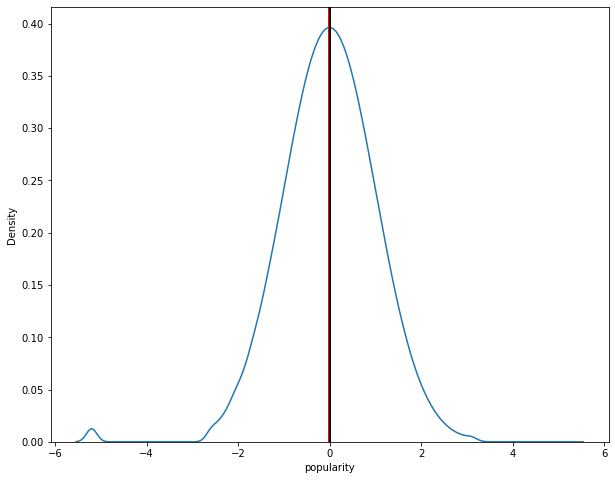

In [26]:
plt.figure(figsize=(10, 8))
sns.kdeplot(df_scaled['popularity'])

plt.axvline(df_scaled['popularity'].mean(), linewidth = 2, color = 'r')
plt.axvline(df_scaled['popularity'].median(), linewidth = 2, color = 'k')
plt.show()

In [27]:
df_scaled['popularity'] = (df_scaled['popularity'] - df_scaled['popularity'].min()) / (df_scaled['popularity'].max() - df_scaled['popularity'].min()) * 100

In [ ]:
plt.figure(figsize=(10, 8))
sns.kdeplot(df_scaled['popularity'])

plt.axvline(df_scaled['popularity'].mean(), linewidth = 2, color = 'r')
plt.axvline(df_scaled['popularity'].median(), linewidth = 2, color = 'k')
plt.show()

In [ ]:
plt.figure(figsize=(16, 8))
sns.pairplot(data=df_scaled,
                  x_vars=['artist_followers', 'loudness', 'danceability'],
                  y_vars=['popularity'], kind="kde")
plt.show()

In [ ]:
plt.figure(figsize=(16, 8))
sns.pairplot(data=df_scaled,
                  x_vars=['energy', 'speechiness', 'acoustics', 'instrumentalness'],
                  y_vars=['popularity'], kind="kde")
plt.show()

In [ ]:
sns.pairplot(data=df_scaled,
                  x_vars=['liveness', 'valence', 'tempo', 'duration_min'],
                  y_vars=['popularity'], kind="kde")

### Modelling

In [28]:
y = df_selected['popularity']
X = df_selected.drop(["popularity"],axis=1)

#### 1. Linear Regression

First, we would like to see how our numerical features perform first.

In [29]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

In [30]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)
train_pred = lm.predict(X_train)
test_pred = lm.predict(X_test)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])

Test set evaluation:
_____________________________________
MAE: 22237.91132816655
MSE: 5800011293.619931
RMSE: 76157.80520485035
R2 Square 0.0772471524220727
__________________________________
Train set evaluation:
_____________________________________
MAE: 22778.4218895889
MSE: 7737494906.738011
RMSE: 87963.03147764981
R2 Square 0.05310398206691225
__________________________________


The lower value of MAE, MSE, and RMSE implies higher accuracy of a regression model. However, a higher value of R square is considered desirable.

R-squared is always between 0 and 100%:

- 0% represents a model that does not explain any of the variation in the response variable around its mean. The mean of the dependent variable predicts the dependent variable as well as the regression model.
- 100% represents a model that explains all the variation in the response variable around its mean.

So, if the R2 of a model is 0.50, then approximately half of the observed variation can be explained by the model’s inputs. And by our case, it's almost near zero, then the model doesn't represent the overall variance of the variables.

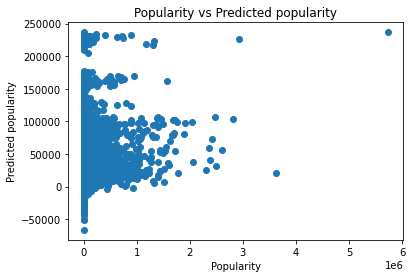

In [31]:
# Visualizing the differences between actual prices and predicted values
plt.scatter(y_train, train_pred)
plt.xlabel("Popularity")
plt.ylabel("Predicted popularity")
plt.title("Popularity vs Predicted popularity")
plt.show()

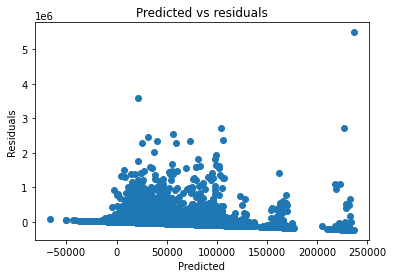

In [32]:
# Checking residuals
plt.scatter(train_pred,y_train-train_pred)
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

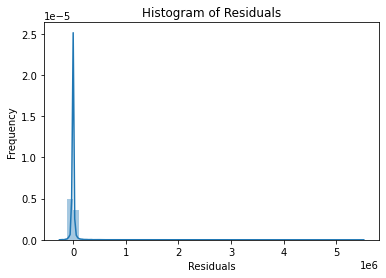

In [33]:
# Checking Normality of errors
sns.distplot(y_train-train_pred)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

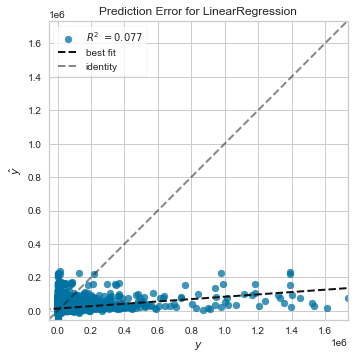

<AxesSubplot:title={'center':'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [34]:
from yellowbrick.regressor import PredictionError
visualizer = PredictionError(lm)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

#### 2. Random Forest Regressor

In [35]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=500)
rf_reg.fit(X_train, y_train)

test_pred = rf_reg.predict(X_test)
train_pred = rf_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 23505.32634797512
MSE: 5978744379.8798065
RMSE: 77322.34075530698
R2 Square 0.04881161049750582
__________________________________
Train set evaluation:
_____________________________________
MAE: 9442.602930150928
MSE: 1353654353.4158566
RMSE: 36792.04198486212
R2 Square 0.8343430357813787
__________________________________


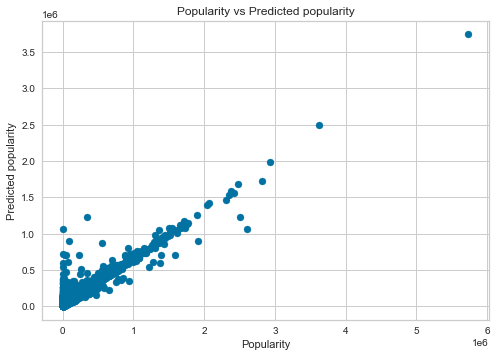

In [37]:
# Visualizing the differences between actual prices and predicted values
plt.scatter(y_train, train_pred)
plt.xlabel("Popularity")
plt.ylabel("Predicted popularity")
plt.title("Popularity vs Predicted popularity")
plt.show()

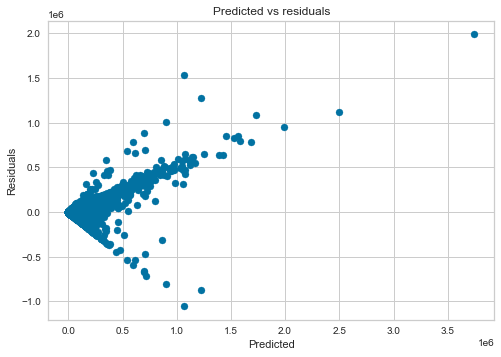

In [38]:
# Checking residuals
plt.scatter(train_pred,y_train-train_pred)
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

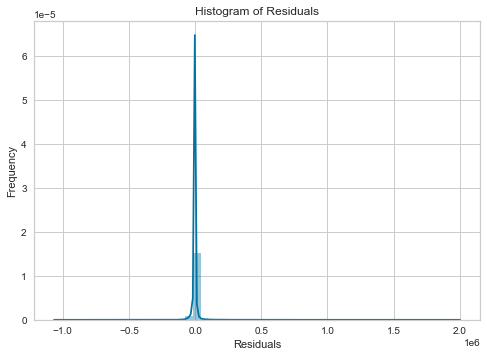

In [39]:
# Checking Normality of errors
sns.distplot(y_train-train_pred)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

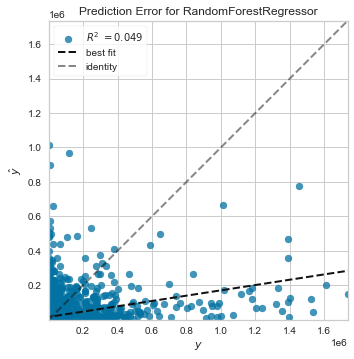

<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [40]:
from yellowbrick.regressor import PredictionError
visualizer = PredictionError(rf_reg)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

#### 3. Lasso Regression

In [41]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.1, 
              precompute=True, 
#               warm_start=True, 
              positive=True, 
              selection='random',
              random_state=42)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Lasso Regression", *evaluate(y_test, test_pred) , cross_val(Lasso())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 22096.67783211313
MSE: 5810590671.556136
RMSE: 76227.23051217417
R2 Square 0.07556402619661617
__________________________________
Train set evaluation:
_____________________________________
MAE: 22574.011679035575
MSE: 7752879166.044512
RMSE: 88050.43535408846
R2 Square 0.05122129341228199
__________________________________


#### 4. Elastic Net

In [42]:
from sklearn.linear_model import ElasticNet

model = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=42)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Elastic Net Regression", *evaluate(y_test, test_pred) , cross_val(ElasticNet())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 22038.858131668636
MSE: 5801535025.643063
RMSE: 76167.80832899857
R2 Square 0.07700473426250176
__________________________________
Train set evaluation:
_____________________________________
MAE: 22549.98026143349
MSE: 7740809598.621029
RMSE: 87981.87085201718
R2 Square 0.052698338046136106
__________________________________


In [43]:
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,22237.911328,5.800011e+09,76157.805205,0.077247,0.055633
1,Random Forest Regressor,23505.326348,5.978744e+09,77322.340755,0.048812,0.000000
2,Lasso Regression,22096.677832,5.810591e+09,76227.230512,0.075564,0.055637
3,Elastic Net Regression,22038.858132,5.801535e+09,76167.808329,0.077005,0.053284


From all of regression algorithms that we tried, random forest regressor turns out to be the best among all of them even though the error rate still remains high and R-squared is still low, which means that the model is not a good fit for now. However, for the next steps, we'll try to focus on lowering the error rate by doing some hyperparameter tuning using random forest regressor since all the linear methods didn't give us satisfying results. And, we'd also like to try popularity classification in the upcoming weeks.